# CAPM Model (calculating the optimum portfolio with 2 stocks)

## By: Reza Kakavand  &  Naimeh Ghare Daghi

Summary: This program downloads the prices of 2 stocks for last year (1 year from today) and calculates the best weights of each to be allocated using CAPM model. Data is downloaded from [Yahoo finance](https://finance.yahoo.com/)


In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### First we define the functions which we're going to use

In [2]:
# FUNCTIONS SECTION
class calculations:

    def download(self, t_symb):
        add_info = yf.Ticker(t_symb)
        print(add_info.info['longName'])
        stock = yf.download(tickers=t_symb, period='1y', interval='1d')  # 1 year period on 1 day intervals
        return stock[0:252]  # [0:252] makes all stocks df the same length

    def pct_change(self, stock):
        column_pc = 'Close'  # uses the 'Close' price to calculate the percent change
        stock_pc = stock[column_pc].pct_change()[1:]
        return stock_pc

    def stock_stats(self, stock_pc):
        # 252 = days of one trading year
        mu = stock_pc.mean() * 252  # yearly mean (return)
        sigma_sq = stock_pc.var() * 252  # yearly variance
        sigma = np.sqrt(sigma_sq)  # yearly standard deviation (risk)
        return mu, sigma_sq, sigma

    def two_stock_stats(self, stock1_pc, stock2_pc):
        cov = np.cov(stock1_pc, stock2_pc)[0][1] * 252  # covariance
        corr = np.corrcoef(stock1_pc, stock2_pc)[0][1]  # correlation
        return cov, corr

### Asking for input

In [3]:
# DATA INPUT AND TRANSFORMATION SECTION

print('\n+---------------------------------+')
print('|  TWO STOCKS PORTFOLIO ANALYSIS  |')
print('+---------------------------------+\n')
calculation_class = calculations()
# stock 1
t_symb1 = input('Ticker symbol stock 1: ')
stock1 = calculation_class.download(t_symb1)
stock1_pc = calculation_class.pct_change(stock1)
stock1_mu, stock1_sigma_sq, stock1_sigma = calculation_class.stock_stats(stock1_pc)

# stock 2
t_symb2 = input('Ticker symbol stock 2: ')
stock2 = calculation_class.download(t_symb2)
stock2_pc = calculation_class.pct_change(stock2)
stock2_mu, stock2_sigma_sq, stock2_sigma = calculation_class.stock_stats(stock2_pc)


+---------------------------------+
|  TWO STOCKS PORTFOLIO ANALYSIS  |
+---------------------------------+

Ticker symbol stock 1: TSLA
Tesla, Inc.
[*********************100%***********************]  1 of 1 completed
Ticker symbol stock 2: AAPL
Apple Inc.
[*********************100%***********************]  1 of 1 completed


### Calculating covariance and correlation coefficient

In [4]:
cov, corr = calculation_class.two_stock_stats(stock1_pc, stock2_pc)

### Downloading the risk free asset data: 10 year US bond yield

In [5]:
rf_t_symb = '^TNX'
print('Risk free asset: {} (10 year US bond yield, annualized)'.format(rf_t_symb))
rf = calculation_class.download(rf_t_symb)
rf_pc = calculation_class.pct_change(rf)
rf_mu = rf_pc.mean() / 10  # yearly

Risk free asset: ^TNX (10 year US bond yield, annualized)
Treasury Yield 10 Years
[*********************100%***********************]  1 of 1 completed


### Creating the portfolio table and calculating of needed statistics for each portfolio combination

In [6]:
# portfolio table (df_pt)
step = 0.001  # steps of the percentage combination (rows of the portfolio table)
pct_stock1 = np.arange(0, 1 + step, step).tolist()
pt = {'Pct. stock1': pct_stock1}
df_pt = pd.DataFrame(pt)
# profits of each portfolio combination
df_pt['Port. mean'] = (df_pt['Pct. stock1'] * stock1_mu + (1 - df_pt['Pct. stock1']) * stock2_mu)
# variance of each portfolio combination
df_pt['Port. variance'] = (((df_pt['Pct. stock1']) ** 2) * stock1_sigma_sq + (
            (1 - df_pt['Pct. stock1']) ** 2) * stock2_sigma_sq + 2 * (
                                       (df_pt['Pct. stock1']) * (1 - df_pt['Pct. stock1']) * cov))
# standard deviation of each portfolio combination
df_pt['Port. standard deviation'] = (np.sqrt(df_pt['Port. variance']))

### Calculating Markowitz global minimum variance portfolio (gmvp)

In [7]:
gmvp_pct_stock1 = (stock2_sigma_sq - cov) / (stock1_sigma_sq + stock2_sigma_sq - 2 * cov)
if gmvp_pct_stock1 > 1:
    gmvp_pct_stock1 = 1
elif gmvp_pct_stock1 < 0:
    gmvp_pct_stock1 = 0
gmvp_pct_stock2 = (1 - gmvp_pct_stock1)

### Calculating gmvp statistics


In [8]:
gmvp_mu = (gmvp_pct_stock1 * stock1_mu + gmvp_pct_stock2 * stock2_mu)
gmvp_sigma_sq = (gmvp_pct_stock1 ** 2) * stock1_sigma_sq + (
        gmvp_pct_stock2 ** 2) * stock2_sigma_sq + 2 * gmvp_pct_stock1 * gmvp_pct_stock2 * cov
gmvp_sigma = np.sqrt(gmvp_sigma_sq)
gmvp_sharpe_ratio = (gmvp_mu - rf_mu) / gmvp_sigma

### Calculating Markowitz optimum market portfolio (omp)

In [9]:
omp_formula_part1 = (stock1_mu - rf_mu) * stock2_sigma_sq - (stock2_mu - rf_mu) * cov
omp_formula_part2 = (stock2_mu - rf_mu) * stock1_sigma_sq + (stock1_mu - rf_mu) * stock2_sigma_sq - (
            stock1_mu + stock2_mu - 2 * rf_mu) * cov
omp_pct_stock1 = omp_formula_part1 / omp_formula_part2
if omp_pct_stock1 > 1:
    omp_pct_stock1 = 1
elif omp_pct_stock1 < 0:
    omp_pct_stock1 = 0
omp_pct_stock2 = (1 - omp_pct_stock1)


### omp statistics


In [10]:
omp_mu = (omp_pct_stock1 * stock1_mu + omp_pct_stock2 * stock2_mu)
omp_sigma_sq = (omp_pct_stock1 ** 2) * stock1_sigma_sq + (
            omp_pct_stock2 ** 2) * stock2_sigma_sq + 2 * omp_pct_stock1 * omp_pct_stock2 * cov
omp_sigma = np.sqrt(omp_sigma_sq)
omp_sharpe_ratio = (omp_mu - rf_mu) / omp_sigma

### Calculating omp and rf combination table (df_omp_rf)

In [11]:
step = 0.001  # steps of the percentage combination (rows of the portfolio table)
pct_omp = np.arange(0, 2 + step, step).tolist()
omp_rf = {'Pct. optimum market portfolio': pct_omp}
df_omp_rf = pd.DataFrame(omp_rf)
# profits of each portfolio combination
df_omp_rf['Port. mean'] = rf_mu + df_omp_rf['Pct. optimum market portfolio'] * (omp_mu - rf_mu)
# variance of each portfolio combination
df_omp_rf['Port. variance'] = (((df_omp_rf['Pct. optimum market portfolio']) ** 2) * omp_sigma_sq)
# standard deviation of each portfolio combination
df_omp_rf['Port. standard deviation'] = (np.sqrt(df_omp_rf['Port. variance']))

## Table of results

In [12]:
input('\nCalculation complete. Press Enter to show results ')

print("\nPER STOCK STATS\n---------------")
table1 = {' ': ['Mean:', 'Variance:', 'Std. Dev.:'],
          t_symb1: [stock1_mu, stock1_sigma_sq, stock1_sigma],
          t_symb2: [stock2_mu, stock2_sigma_sq, stock2_sigma]}
df1 = pd.DataFrame(table1)
df1[t_symb1] = df1[t_symb1].round(3)
df1[t_symb2] = df1[t_symb2].round(3)
print(df1.to_string(index=False))
print(' Covariance: ', cov.round(6))
print('Correlation: ', corr.round(6))

print('\nGLOBAL MINIMUM VARIANCE PORTFOLIO STATS\n---------------------------------------')
table2 = {'Pct. ticker symbol': ['Pct. {}:'.format(t_symb1),
                                 'Pct. {}:'.format(t_symb2),
                                 'Mean:',
                                 'Variance:',
                                 'Std. Dev.:'],
          'data': [gmvp_pct_stock1 * 100, gmvp_pct_stock2 * 100, gmvp_mu, gmvp_sigma_sq, gmvp_sigma]}
df2 = pd.DataFrame(table2)
df2['data'] = df2['data'].round(3)
print(df2.to_string(index=False, header=False))
print('Sharpe ratio: ', round(gmvp_sharpe_ratio, 3))

print('\nOPTIMUM MARKET PORTFOLIO STATS\n------------------------------')
table3 = {'Pct. ticker symbol': ['Pct. {}:'.format(t_symb1),
                                 'Pct. {}:'.format(t_symb2),
                                 'Mean:',
                                 'Variance:',
                                 'Std. Dev.:'],
          'data': [omp_pct_stock1 * 100, omp_pct_stock2 * 100, omp_mu, omp_sigma_sq, omp_sigma]}
df3 = pd.DataFrame(table3)
df3['data'] = df3['data'].round(3)
print(df3.to_string(index=False, header=False))
print('Sharpe ratio: ', round(omp_sharpe_ratio, 3))


Calculation complete. Press Enter to show results 

PER STOCK STATS
---------------
            TSLA  AAPL
     Mean: 0.440 0.265
 Variance: 0.288 0.059
Std. Dev.: 0.536 0.242
 Covariance:  0.06064
Correlation:  0.467438

GLOBAL MINIMUM VARIANCE PORTFOLIO STATS
---------------------------------------
Pct. TSLA:   0.000
Pct. AAPL: 100.000
     Mean:   0.265
 Variance:   0.059
Std. Dev.:   0.242
Sharpe ratio:  1.096

OPTIMUM MARKET PORTFOLIO STATS
------------------------------
Pct. TSLA: 16.366
Pct. AAPL: 83.634
     Mean:  0.294
 Variance:  0.065
Std. Dev.:  0.255
Sharpe ratio:  1.15


## Asking if graphic presentation is needed


Graphic representation? Y/[N] y


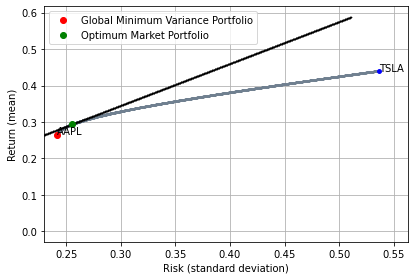


Process finished


In [13]:
g_rep = input('\nGraphic representation? Y/[N] ')

if g_rep == 'Y' or g_rep == 'y':
    ax = plt.subplot()
    ax.grid()
    ax.set_axisbelow(True)
    X_curve = df_pt['Port. standard deviation']
    Y_curve = df_pt['Port. mean']
    X_line = df_omp_rf['Port. standard deviation']
    Y_line = df_omp_rf['Port. mean']
    plt.scatter(X_curve, Y_curve, color='slategray', s=2)
    plt.scatter(X_line, Y_line, color='black', s=0.25)
    plt.scatter(df_pt['Port. standard deviation'].head(1), df_pt['Port. mean'].head(1), color='blue', s=15)
    plt.scatter(df_pt['Port. standard deviation'].tail(1), df_pt['Port. mean'].tail(1), color='blue', s=15)
    ax.plot(gmvp_sigma, gmvp_mu, "ro", label='Global Minimum Variance Portfolio')
    ax.plot(omp_sigma, omp_mu, "go", label='Optimum Market Portfolio')
    plt.xlabel('Risk (standard deviation)')
    plt.ylabel('Return (mean)')
    plt.text(df_pt['Port. standard deviation'].head(1), df_pt['Port. mean'].head(1), t_symb2)
    plt.text(df_pt['Port. standard deviation'].tail(1), df_pt['Port. mean'].tail(1), t_symb1)
    plt.tight_layout()
    ax.set_xlim(gmvp_sigma * (1 - 0.05))
    plt.legend(loc="upper left")
    plt.show()
    plt.close()
    print('\nProcess finished')
else:
    print('\nProcess finished')